In [ ]:
pip install Keras-Preprocessing


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import os
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report,confusion_matrix
from keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


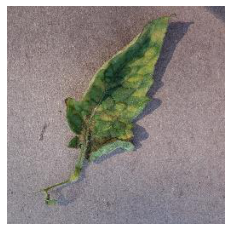

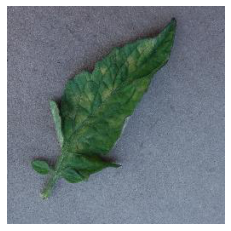

In [ ]:
train_dir = os.path.join("/content/drive/MyDrive/Tomato_db/train") #Train directory
test_dir = os.path.join("/content/drive/MyDrive/Tomato_db/test") # Test Directory
tomato_files = os.path.join("/content/drive/MyDrive/Tomato_db/train/Tomato___Leaf_Mold")#directory for plotting sample images
tomato_image = os.listdir(tomato_files) # Listing all the images from directory
pic_index = 20
next_plant = [os.path.join(tomato_files, fname) 
                for fname in tomato_image[pic_index-2:pic_index]]
for i, img_path in enumerate(next_plant):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

In [ ]:
# Data Augmentation
# Global Variables
IMG_WIDTH = 224 #Width of image
IMG_HEIGHT = 224 # Height of Image
BATCH_SIZE = 32 # Batch Size 
train_data_size = 7001 #
test_data_size = 3001
train_data = ImageDataGenerator(
                rescale = 1./255, #normalizing the input image
                rotation_range = 0.2,
                vertical_flip=True,
                fill_mode='nearest')
test_data = ImageDataGenerator(
                rescale = 1./255)
train_set = train_data.flow_from_directory(
                train_dir,
                target_size=(IMG_WIDTH,IMG_HEIGHT),
                batch_size=BATCH_SIZE,
                class_mode = 'categorical')
test_set = test_data.flow_from_directory(
                test_dir,
                target_size = (IMG_WIDTH,IMG_HEIGHT),
                batch_size = BATCH_SIZE,
                shuffle=False,
                class_mode = 'categorical')

Found 7001 images belonging to 10 classes.
Found 3001 images belonging to 10 classes.


In [ ]:
labels_values,no_of_images = np.unique(train_set.classes,return_counts = True)
dict(zip(train_set.class_indices,no_of_images))
labels = test_set.class_indices
labels = { v:k for k,v in labels.items() } # Flipping keys and values
values_lbl = list(labels.values()) # Taking out only values from dictionary

In [ ]:
# Defining all layers.
dense = tf.keras.layers.Dense
conv = tf.keras.layers.Conv2D
max_pooling = tf.keras.layers.MaxPooling2D
flatten = tf.keras.layers.Flatten()
dropout = tf.keras.layers.Dropout(0.2)
# Sequential Model
model = tf.keras.Sequential()
# 1st layer
model.add(conv(16,(3,3),input_shape = (IMG_WIDTH,IMG_HEIGHT,3),padding='same',activation='relu'))
model.add(max_pooling(2,2))
# 2nd Layer
model.add(conv(32,(3,3),padding='same',activation='relu'))
model.add(max_pooling(2,2))
# Flatten Layer
model.add(flatten)
# 1st Hidden Layer
model.add(dense(512,activation='relu',))
model.add(dropout)
# 2nd Hidden Layer
model.add(dense(256,activation='relu'))
# Output Layer
model.add(dense(10,activation='softmax'))

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               5

In [ ]:
# Compiling model
model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),metrics=['acc'] )

In [ ]:
history_model = model.fit(train_set,steps_per_epoch = 2,
                          epochs=3,
                          validation_data=test_set,
                          validation_steps = test_data_size // BATCH_SIZE+1,
                          verbose=1,
                          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 5)])

Epoch 1/3
2/2 [==============================] - 198s 192s/step - loss: 2.0399 - acc: 0.2500 - val_loss: 2.0339 - val_acc: 0.2602
Epoch 2/3
2/2 [==============================] - 21s 14s/step - loss: 2.3748 - acc: 0.1094 - val_loss: 2.4502 - val_acc: 0.1030
Epoch 3/3
2/2 [==============================] - 20s 15s/step - loss: 2.1971 - acc: 0.1719 - val_loss: 2.1425 - val_acc: 0.2469


In [ ]:
#Save our model
model.save("model-1.h5")

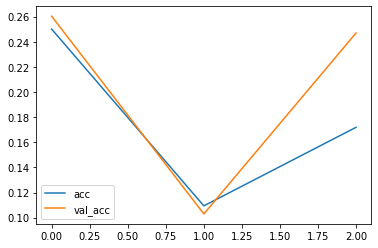

In [ ]:
# Accuracy comparison
plt.plot(history_model.history['acc'])
plt.plot(history_model.history['val_acc'])
plt.legend(['acc','val_acc'])
plt.show()

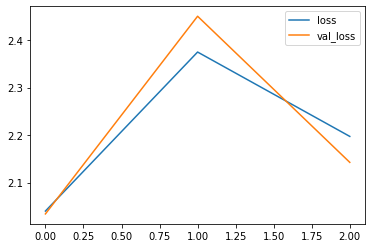

In [ ]:
# Loss Comparison
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [ ]:
y_test = test_set.classes
#predicting our model with test dataset i.e. unseen dataset
pred =model.predict_generator(test_set,test_data_size//BATCH_SIZE+1,verbose=1,).argmax(axis=1)
#Classification report of every label
print(classification_report(y_test,pred))

<ipython-input-25-9d007e052c5d>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred =model.predict_generator(test_set,test_data_size//BATCH_SIZE+1,verbose=1,).argmax(axis=1)


94/94 [==============================] - 11s 115ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       300
           1       0.33      0.01      0.03       300
           2       0.00      0.00      0.00       301
           3       0.17      0.92      0.29       300
           4       0.21      0.42      0.28       300
           5       0.70      0.31      0.43       300
           6       0.00      0.00      0.00       300
           7       0.00      0.00      0.00       300
           8       0.28      0.41      0.34       300
           9       0.62      0.40      0.48       300

    accuracy                           0.25      3001
   macro avg       0.23      0.25      0.18      3001
weighted avg       0.23      0.25      0.18      3001



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


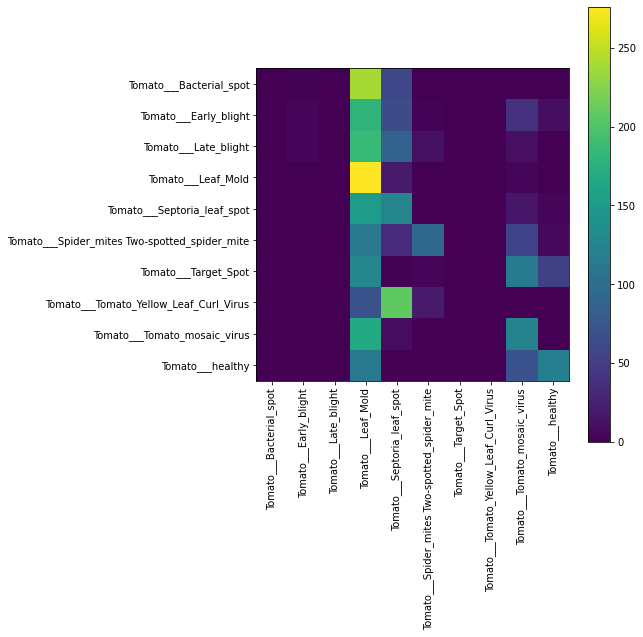

In [ ]:
conf = confusion_matrix(y_test,pred)
plt.figure(figsize=(7,8))
plt.imshow(conf, interpolation='nearest')
plt.colorbar()
plot_mark = np.arange(len(values_lbl))
_ = plt.xticks(plot_mark, values_lbl,   

In [ ]:
#Total number of wrong prediction from our test dataset.
total_count=0
for i in range(len(y_test)):
  if y_test[i] != pred[i]:
    total_count += 1
print('Total number of test cases', ((len(y_test))))
print('Number of wrong predictions', total_count)

Total number of test cases 3001
Number of wrong predictions 2260


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  img = image.load_img('/content/' + fn,target_size=(224,224,3))
  img = image.img_to_array(img)
  img = img/255
proba = model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(1):
  print("Label: {}".format(labels[top_3[i]]))
  print("Accuracy: {:2}".format(proba[0][top_3[i]]*100))
plt.imshow(img)

NameError: ignored